# Data Science Challenge

In [1]:
# If additional packages are needed that are not installed by default, uncomment the last two lines of this 
# cell and replace <package list> with a list of additional packages.
# This will ensure the notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>

In [2]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 101)

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
models = [
          LinearRegression(),
          Ridge(),
          HuberRegressor(),
          ElasticNetCV(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          ExtraTreesRegressor(),
          GradientBoostingRegressor()
         ]

## Data Description

Column | Description
:---|:---
`id` | Record index
`timestamp` | Datetime (YYYY:MM:DD HH AM/PM)
`season` | Season (spring, summer, fall, winter)
`holiday` | Whether day is a holiday or not (Yes or No)
`workingday` | Whether day is a working day or not (Yes or No)
`weather`| Weather condition (Clear or partly cloudy, Mist, Light snow or rain, heavy rain/ice pellets/ snow + fog 
`temp`| Average temperature recorded for the hour ( in degree Celsius)
`temp_feel`| Average feeling temperature recorded for the hour ( in degree Celsius)
`hum`| Average humidity recorded for the hour (in %)
`windspeed`| Average wind speed recorded for the hour (in miles/hour)
`demand`| Hourly count of bikes rented

## Data Wrangling & Visualization

In [3]:
# Dataset
data = pd.read_csv("train.csv")

In [4]:
# Dataset structure
# definitely need to feature engineer all categorical data
# from timestamp we can take out month, weekday, hour, year
data.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand
0,1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589
1,2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879
2,3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736
3,4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949
4,5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000


In [5]:
# Explore columns
data.columns

Index(['id', 'timestamp', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'temp_feel', 'humidity', 'windspeed', 'demand'],
      dtype='object')

In [6]:
# Numerical data description
# Counts are not matching so there is missing data
data.describe()

,id,temp,temp_feel,humidity,windspeed,demand
count,8708.000000,7506.000000,8606.000000,8669.00000,8508.000000,8708.000000
mean,4354.500000,20.089454,23.531261,60.99354,13.048589,4.452725
std,2513.927405,8.023304,8.737997,19.67989,8.311058,1.493963
min,1.000000,0.820000,0.760000,0.00000,0.000000,0.000000
25%,2177.750000,13.940000,15.910000,46.00000,7.001500,3.637586
50%,4354.500000,20.500000,24.240000,60.00000,12.998000,4.867534
75%,6531.250000,26.240000,31.060000,77.00000,19.001200,5.556828
max,8708.000000,41.000000,45.455000,100.00000,56.996900,6.792344


In [7]:
# Datatype Info
# we can change timestamp to datatime, and rest of objects to category
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          8708 non-null   int64  
 1   timestamp   8708 non-null   object 
 2   season      8708 non-null   object 
 3   holiday     8708 non-null   object 
 4   workingday  8708 non-null   object 
 5   weather     8708 non-null   object 
 6   temp        7506 non-null   float64
 7   temp_feel   8606 non-null   float64
 8   humidity    8669 non-null   float64
 9   windspeed   8508 non-null   float64
 10  demand      8708 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 748.5+ KB


In [8]:
# Checking for null values
# temp and temp_feel are too similar so we will drop the one with most null values
data.isnull().sum()

id               0
timestamp        0
season           0
holiday          0
workingday       0
weather          0
temp          1202
temp_feel      102
humidity        39
windspeed      200
demand           0
dtype: int64

In [9]:
# Change timestamp to datetime and create new columns
# hours: 0-23, month 1-12, weekday: monday=0, sunday=6
data['timestamp'] = pd.to_datetime(data['timestamp'])

data['weekday'] = pd.DatetimeIndex(data['timestamp']).weekday
data['month'] = pd.DatetimeIndex(data['timestamp']).month
data['year'] = pd.DatetimeIndex(data['timestamp']).year
data['hour'] = pd.DatetimeIndex(data['timestamp']).hour

In [10]:
# Change rest of objects to category
cols = ['season', 'holiday', 'workingday', 'weather', 'weekday', 'month', 'year', 'hour']
for col in cols:
    data[col] = data[col].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          8708 non-null   int64         
 1   timestamp   8708 non-null   datetime64[ns]
 2   season      8708 non-null   category      
 3   holiday     8708 non-null   category      
 4   workingday  8708 non-null   category      
 5   weather     8708 non-null   category      
 6   temp        7506 non-null   float64       
 7   temp_feel   8606 non-null   float64       
 8   humidity    8669 non-null   float64       
 9   windspeed   8508 non-null   float64       
 10  demand      8708 non-null   float64       
 11  weekday     8708 non-null   category      
 12  month       8708 non-null   category      
 13  year        8708 non-null   category      
 14  hour        8708 non-null   category      
dtypes: category(8), datetime64[ns](1), float64(5), int64(1)
memory usage: 54

In [11]:
# Unique values
# we can apply one-hot encoding to season, holiday, workingday, & weather
data.apply(lambda x: len(x.unique()))

id            8708
timestamp     8708
season           4
holiday          2
workingday       2
weather          4
temp            50
temp_feel       61
humidity        89
windspeed       29
demand         742
weekday          7
month           12
year             2
hour            24
dtype: int64

[Text(0.5, 1.0, 'Demand by Weekday')]

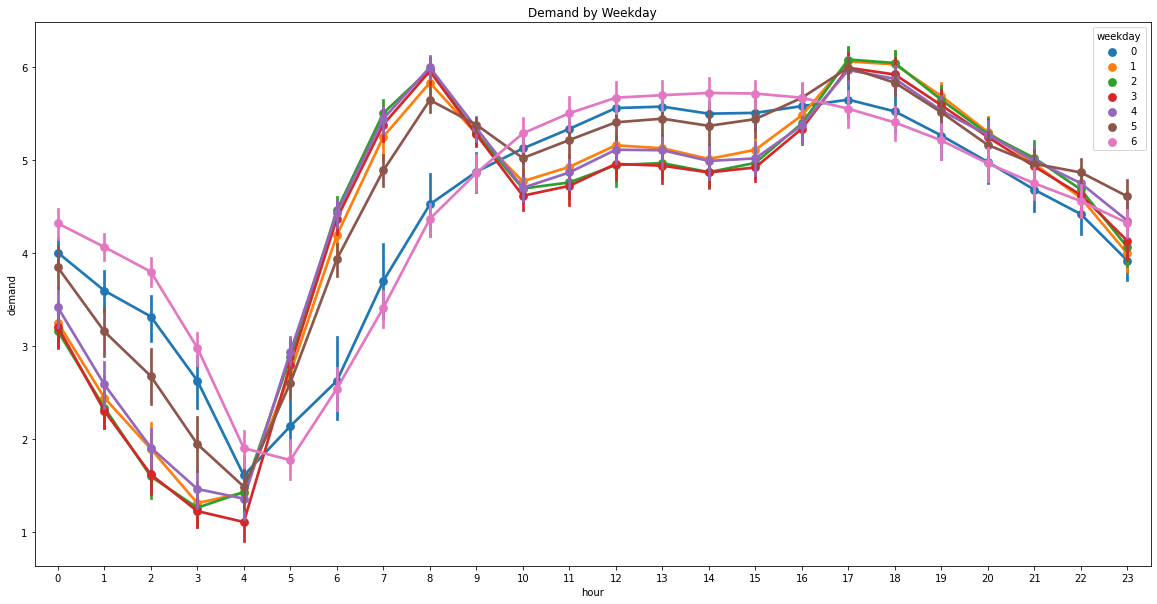

In [12]:
# Visualizing demand by hour by day of week
# sunday and monday morning have low demand but in afternoon more than weekdays
fig, ax = plt.subplots(figsize=(20, 10))
sns.pointplot(data=data, x='hour', y='demand', hue='weekday', ax=ax)
ax.set(title='Demand by Weekday')

[Text(0.5, 1.0, 'Demand by Weather')]

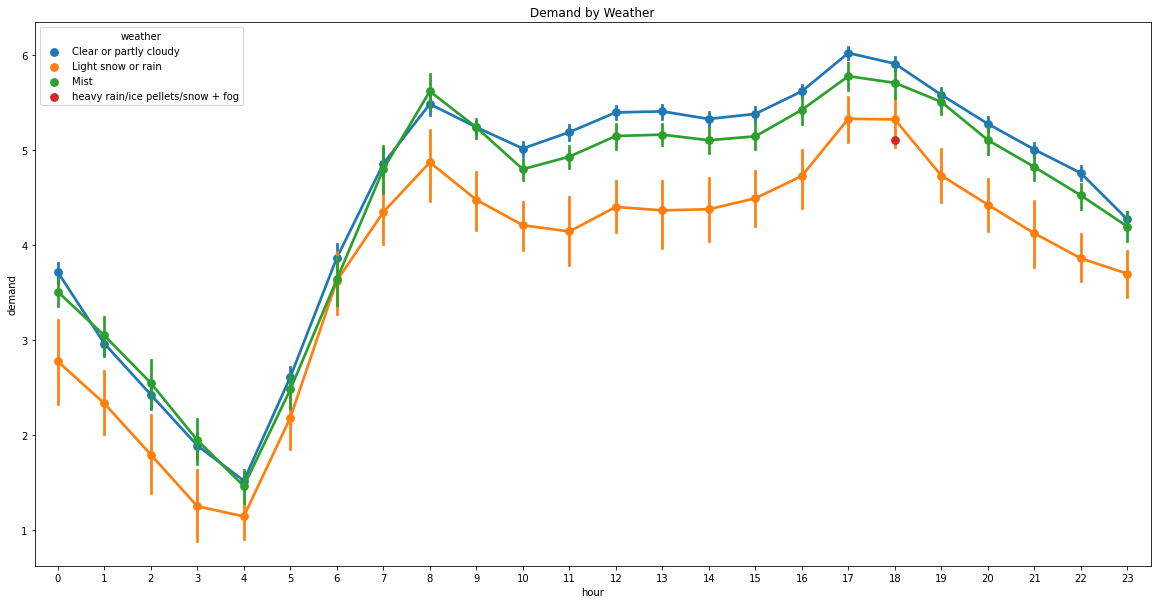

In [13]:
# Visualizing demand by hour with respect to weather
# heavy rain and snow have little to no demand, clear and light weather result in higher demand
fig, ax = plt.subplots(figsize=(20, 10))
sns.pointplot(data=data, x='hour', y='demand', hue='weather', ax=ax)
ax.set(title='Demand by Weather')

[Text(0.5, 1.0, 'Demand by Season')]

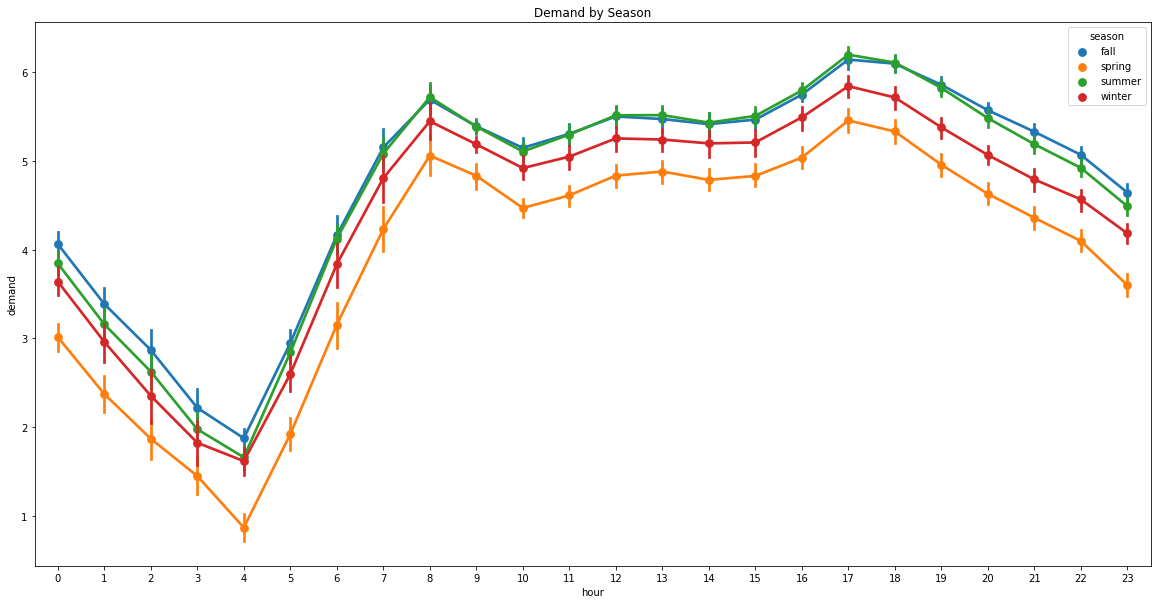

In [14]:
# Visualizing demand by hour with respect to season
# summer and fall have higher demands than winter, spring is lowest
fig, ax = plt.subplots(figsize=(20, 10))
sns.pointplot(data=data, x='hour', y='demand', hue='season', ax=ax)
ax.set(title='Demand by Season')

[Text(0.5, 1.0, 'Demand by Month')]

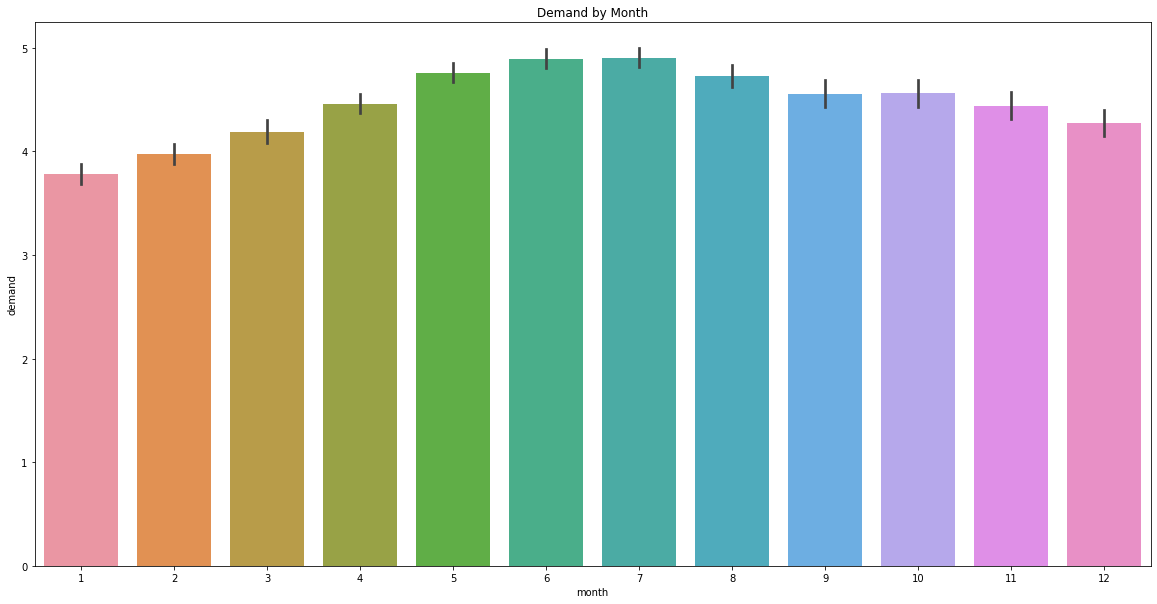

In [15]:
# Seeing demand over span of month
# seems to be in agreement with seasons
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=data, x='month', y='demand', ax=ax)
ax.set(title='Demand by Month')

[Text(0.5, 1.0, 'Demand by Weekday')]

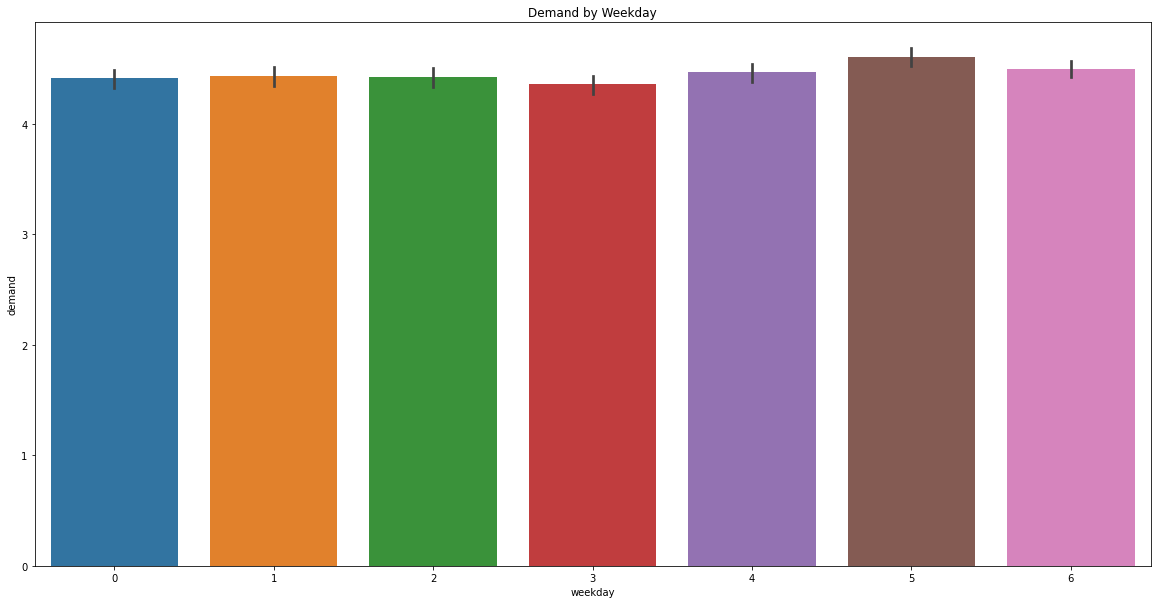

In [16]:
# Seeing demand over span of weekday
# not much info
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=data, x='weekday', y='demand', ax=ax)
ax.set(title='Demand by Weekday')

<AxesSubplot:>

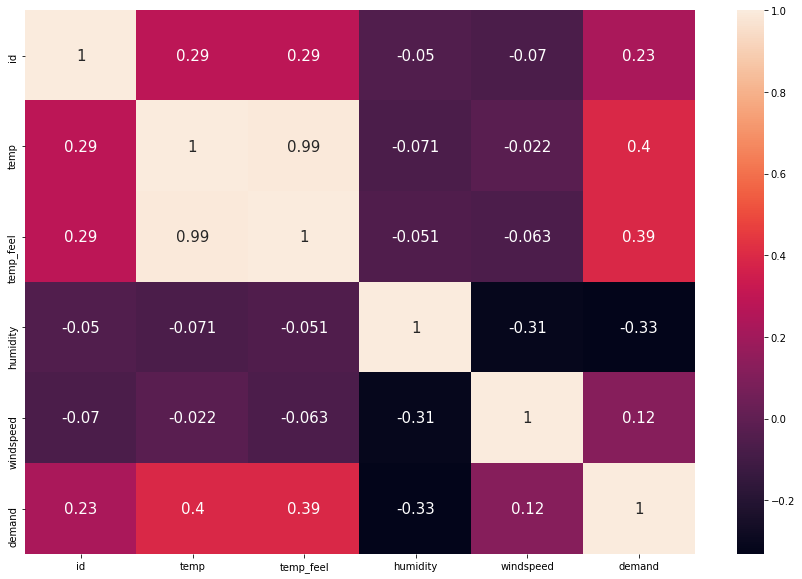

In [17]:
# Coorelation Matrix
# we can drop windspeed since we see a weak correlation
corr = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, annot_kws={'size': 15})

[Text(0.5, 1.0, 'Humidity-Demand Graph')]

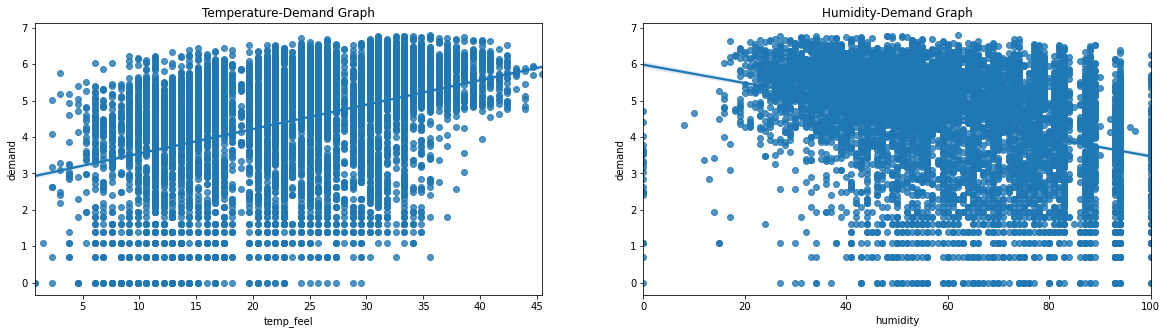

In [18]:
# Visualizing the demand with respect to relevant numerical features
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
sns.regplot(x=data['temp_feel'], y=data['demand'], ax=ax1)
ax1.set(title='Temperature-Demand Graph')
sns.regplot(x=data['humidity'], y=data['demand'], ax=ax2)
ax2.set(title='Humidity-Demand Graph')

[Text(0.5, 1.0, 'Theoretical Quantiles')]

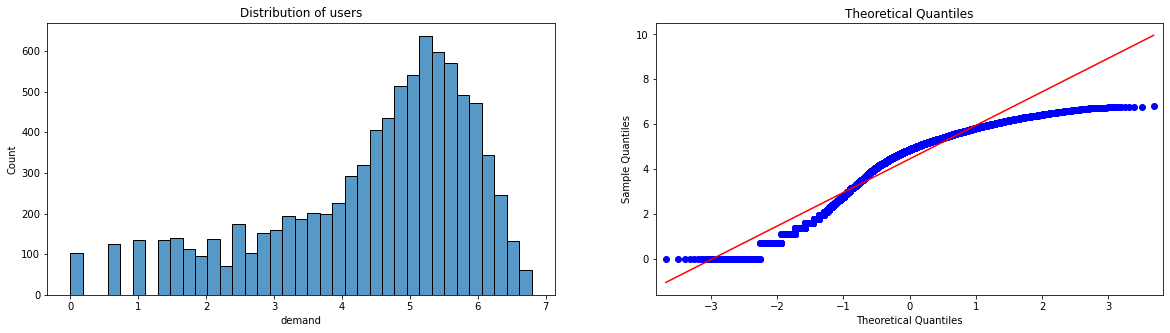

In [19]:
# Viewing user distribution and theoretical quantiles
# demand seems to be normalized already
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
sns.histplot(data['demand'], ax=ax1)
ax1.set(title='Distribution of users')
qqplot(data['demand'], ax=ax2, line='s')
ax2.set(title='Theoretical Quantiles')

In [20]:
# One-hot encoding categorical features
data_ohe = data

def ohe(data, column):
    data = pd.concat([data, pd.get_dummies(data[column], prefix=column, drop_first=True)], axis=1)
    data = data.drop([column], axis=1)
    return data

cols = ['season', 'holiday', 'workingday', 'weather', 'weekday', 'month', 'year', 'hour']

for col in cols:
    data_ohe = ohe(data_ohe, col)

In [21]:
# Dropping columns for final features
data_ohe = data_ohe.drop(columns=['windspeed', 'id', 'temp', 'timestamp'])
data_ohe.head()

,temp_feel,humidity,demand,season_spring,season_summer,season_winter,holiday_Yes,workingday_Yes,weather_Light snow or rain,weather_Mist,weather_heavy rain/ice pellets/snow + fog,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2018,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,14.395,81.0,2.772589,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13.635,80.0,3.688879,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13.635,80.0,3.465736,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14.395,75.0,2.564949,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,14.395,75.0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
# Dropping rows that have null values
data_ohe = data_ohe.dropna(axis=0)
data_ohe.isnull().sum()

temp_feel                                    0
humidity                                     0
demand                                       0
season_spring                                0
season_summer                                0
season_winter                                0
holiday_Yes                                  0
workingday_Yes                               0
weather_Light snow or rain                   0
weather_Mist                                 0
weather_heavy rain/ice pellets/snow + fog    0
weekday_1                                    0
weekday_2                                    0
weekday_3                                    0
weekday_4                                    0
weekday_5                                    0
weekday_6                                    0
month_2                                      0
month_3                                      0
month_4                                      0
month_5                                      0
month_6      

In [23]:
# Normalizing temp_feel, humidity
cols = ['temp_feel', 'humidity']

for col in cols:
    data_ohe[col] = (data_ohe[col] - data_ohe[col].min()) / (data_ohe[col].max() - data_ohe[col].min())
    
data_ohe.head()

,temp_feel,humidity,demand,season_spring,season_summer,season_winter,holiday_Yes,workingday_Yes,weather_Light snow or rain,weather_Mist,weather_heavy rain/ice pellets/snow + fog,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2018,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.305068,0.81,2.772589,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.288064,0.80,3.688879,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.288064,0.80,3.465736,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.305068,0.75,2.564949,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.305068,0.75,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Visualization, Modeling, Machine Learning

Build a model that can predict hourly demand and identify how different features influence the decision. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of mean absolute error.**
- **Read the test.csv file and prepare features for testing.**

In [24]:
# Loading test data
test_data=pd.read_csv('test.csv')
test_data.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed
0,8709,2018-08-05 05:00:00,fall,No,No,Clear or partly cloudy,29.52,34.850,74.0,16.9979
1,8710,2018-08-05 06:00:00,fall,No,No,Clear or partly cloudy,29.52,34.850,79.0,16.9979
2,8712,2018-08-05 08:00:00,fall,No,No,Clear or partly cloudy,31.16,36.365,66.0,22.0028
3,8713,2018-08-05 09:00:00,fall,No,No,Clear or partly cloudy,32.80,38.635,59.0,23.9994
4,8714,2018-08-05 10:00:00,fall,No,No,Clear or partly cloudy,32.80,38.635,59.0,27.9993


In [25]:
# Getting X and y from dataset
X = data_ohe.drop(columns=['demand'])
y = data_ohe['demand']

In [26]:
# K-Fold cross validation 
def train(model):
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    pred = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
    cv_score = pred.mean()
    print(f'Model: {model} CV Score: {cv_score}')

In [27]:
# Compraing models
# Random forest, Extra trees are best tree algorithms
# Ridge is best linear algorithm
for model in models: 
    train(model)

Model: LinearRegression() CV Score: -4.814605197298384e+23
Model: Ridge() CV Score: -0.3932753711960557


C:\Users\Angel\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Angel\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Angel\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

Model: HuberRegressor() CV Score: -0.4238572794207799
Model: ElasticNetCV() CV Score: -0.3935511522978359
Model: DecisionTreeRegressor() CV Score: -0.41898424682039437
Model: RandomForestRegressor() CV Score: -0.23497593495169472
Model: ExtraTreesRegressor() CV Score: -0.20633498561032707
Model: GradientBoostingRegressor() CV Score: -0.3121681072514345


In [28]:
# Splitting train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [29]:
# Testing random forest
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

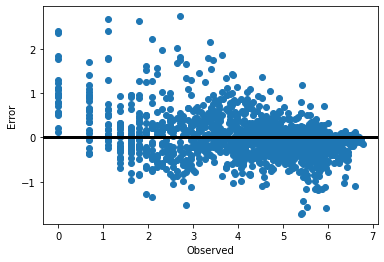

In [30]:
# Plotting error on graph
error = y_pred - y_test
fig, ax = plt.subplots()
ax.scatter(y_test, error)
ax.axhline(lw=3, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Error')
plt.show()

In [31]:
# L1 loss is desired by challenge
np.sqrt(mean_absolute_error(y_pred, y_test))

0.5672311847227886

In [32]:
# Testing ridge
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

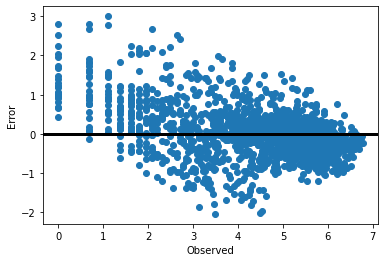

In [33]:
# Ridge: Plotting error on graph
error = y_pred - y_test
fig, ax = plt.subplots()
ax.scatter(y_test, error)
ax.axhline(lw=3, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Error')
plt.show()

In [34]:
# Ridge: L2 loss
np.sqrt(mean_absolute_error(y_pred, y_test))

0.6878141761911836

In [35]:
# Testing extra trees
model = ExtraTreesRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

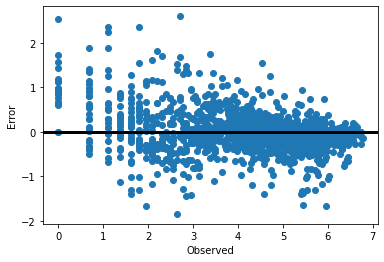

In [36]:
# Extra trees: Plotting error on graph
error = y_pred - y_test
fig, ax = plt.subplots()
ax.scatter(y_test, error)
ax.axhline(lw=3, color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Error')
plt.show()

In [37]:
# Extra trees: L2 loss
# looks like extra trees preformed the best so we will keep this as model
np.sqrt(mean_absolute_error(y_pred, y_test))

0.5332097656775995

> #### Task:
- **Submit the predictions on the test dataset using the optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `demand` variable. Submit a CSV file with a header row and one row per test entry.
    
The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **demand**

In [38]:
# Seeing new dataset structure
# need to process like trained dataset
test_data.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed
0,8709,2018-08-05 05:00:00,fall,No,No,Clear or partly cloudy,29.52,34.850,74.0,16.9979
1,8710,2018-08-05 06:00:00,fall,No,No,Clear or partly cloudy,29.52,34.850,79.0,16.9979
2,8712,2018-08-05 08:00:00,fall,No,No,Clear or partly cloudy,31.16,36.365,66.0,22.0028
3,8713,2018-08-05 09:00:00,fall,No,No,Clear or partly cloudy,32.80,38.635,59.0,23.9994
4,8714,2018-08-05 10:00:00,fall,No,No,Clear or partly cloudy,32.80,38.635,59.0,27.9993


In [40]:
# Saving id column for output before processing
submission_df = test_data.filter(['id'])

In [41]:
# Processing to match trained dataset
# got to add some columns such as months
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])
test_data['weekday'] = pd.DatetimeIndex(test_data['timestamp']).weekday
test_data['month'] = pd.DatetimeIndex(test_data['timestamp']).month
test_data['year'] = pd.DatetimeIndex(test_data['timestamp']).year
test_data['hour'] = pd.DatetimeIndex(test_data['timestamp']).hour

cols = ['season', 'holiday', 'workingday', 'weather', 'weekday', 'month', 'year', 'hour']
for col in cols:
    test_data[col] = test_data[col].astype('category')
    
cols = ['season', 'holiday', 'workingday', 'weather', 'weekday', 'month', 'year', 'hour']
for col in cols:
    test_data = ohe(test_data, col)

test_data = test_data.drop(columns=['windspeed', 'id', 'temp', 'timestamp'])

cols = ['temp_feel', 'humidity']

for col in cols:
    test_data[col] = (test_data[col] - test_data[col].min()) / (test_data[col].max() - test_data[col].min())
    
test_data.head()

,temp_feel,humidity,season_winter,holiday_Yes,workingday_Yes,weather_Light snow or rain,weather_Mist,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_9,month_10,month_11,month_12,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.772761,0.690476,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.772761,0.750000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.818209,0.595238,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.886306,0.511905,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.886306,0.511905,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
# Comparing the test_data to X
X.head()

,temp_feel,humidity,season_spring,season_summer,season_winter,holiday_Yes,workingday_Yes,weather_Light snow or rain,weather_Mist,weather_heavy rain/ice pellets/snow + fog,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2018,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.305068,0.81,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.288064,0.80,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.288064,0.80,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.305068,0.75,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.305068,0.75,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
# Adding necessary columns
test_data.insert(2, 'season_spring', 0)
test_data.insert(3, 'season_summer', 0)
test_data.insert(9, 'weather_heavy rain/ice pellets/snow + fog', 0)
for i in range(2, 9):
    test_data.insert(14 + i, f'month_{i}', 0)
test_data.insert(27, 'year_2018', 0)
test_data.head()

,temp_feel,humidity,season_spring,season_summer,season_winter,holiday_Yes,workingday_Yes,weather_Light snow or rain,weather_Mist,weather_heavy rain/ice pellets/snow + fog,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2018,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.772761,0.690476,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.772761,0.750000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.818209,0.595238,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.886306,0.511905,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.886306,0.511905,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
# Making sure no null values
# ready to go!
test_data.isnull().sum()

temp_feel                                    0
humidity                                     0
season_spring                                0
season_summer                                0
season_winter                                0
holiday_Yes                                  0
workingday_Yes                               0
weather_Light snow or rain                   0
weather_Mist                                 0
weather_heavy rain/ice pellets/snow + fog    0
weekday_1                                    0
weekday_2                                    0
weekday_3                                    0
weekday_4                                    0
weekday_5                                    0
weekday_6                                    0
month_2                                      0
month_3                                      0
month_4                                      0
month_5                                      0
month_6                                      0
month_7      

In [45]:
pred = model.predict(test_data)
submission_df['demand'] = pred
submission_df.head()

,id,demand
0,8709,2.398555
1,8710,3.018385
2,8712,4.826758
3,8713,5.339530
4,8714,5.634877


In [46]:
# Submission
submission_df.to_csv('submissions.csv', index=False)

---